
#use multinomial naive bayes algorithm after the other models

# Imports

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import wrangle, model

from importlib import reload
from itertools import product
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint


In [2]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/codeup-data-science/nlp_project/wrangle.py'>

In [3]:
df = wrangle.get_search_csv()
df = wrangle.prep_text(df)


Removed 190 stopwords
---

Removed 2 stopwords
---

Removed 211 stopwords
---

Removed 401 stopwords
---

Removed 50 stopwords
---

Removed 8 stopwords
---

Removed 158 stopwords
---

Removed 21 stopwords
---

Removed 32 stopwords
---

Removed 110 stopwords
---

Removed 500 stopwords
---

Removed 494 stopwords
---

Removed 31 stopwords
---

Removed 427 stopwords
---

Removed 76 stopwords
---

Removed 175 stopwords
---

Removed 731 stopwords
---

Removed 68 stopwords
---

Removed 58 stopwords
---

Removed 358 stopwords
---

Removed 41 stopwords
---

Removed 15 stopwords
---

Removed 48 stopwords
---

Removed 100 stopwords
---

Removed 111 stopwords
---

Removed 0 stopwords
---

Removed 134 stopwords
---

Removed 242 stopwords
---

Removed 27 stopwords
---

Removed 74 stopwords
---

Removed 88 stopwords
---

Removed 8 stopwords
---

Removed 270 stopwords
---

Removed 123 stopwords
---

Removed 389 stopwords
---

Removed 81 stopwords
---

Removed 187 stopwords
---

Removed 23 stopwords
-

In [4]:
#df = df[['language', 'lemmatized']]

# for i in df.index:
#     df.loc[i, 'word_count'] = len([word for word in df.loc[i, 'lemmatized'].split()])
# df.word_count

# Modeling

## Fit Vectorizer

# Setup
Explore various models and feature combinations.
Choose **three** models to validate. Choose **one** to test. 
Artifact: `model.py`

### Modeling Preparation
- Create function to vectorize, scale, and split data
- Create word_count feature --> backport to wrangle

### Baseline Prediction and Accuracy

In [8]:

def vectorize_split(df):

    """ 
    Purpose:
        
    ---
    Parameters:
        
    ---
    Returns:
        X_train, y_train, X_validate, y_validate, X_test, y_test: data subsets
    """

    tfidf = TfidfVectorizer()
    df['lemmatized'] = tfidf.fit_transform(df.lemmatized).todense()

    scaler = preprocessing.MinMaxScaler()
    scaler.fit_transform(df[['word_count']])

    train_validate, test = train_test_split(df, test_size=.3, random_state=514, stratify=df['language'])
    train, validate = train_test_split(train_validate, test_size=.3, random_state=514, stratify=train_validate['language'])

    # split data into Big X, small y sets 
    X_train = train.drop(columns=['language'])
    y_train = train.language

    X_validate = validate.drop(columns=['language'])
    y_validate = validate.language

    X_test = test.drop(columns=['language'])
    y_test = test.language

    return train, X_train, y_train, X_validate, y_validate, X_test, y_test

In [9]:
train, X_train, y_train, X_validate, y_validate, X_test, y_test = vectorize_split(df)

In [10]:
# formulate baseline prediction ->base prediction is python
train.language.value_counts(normalize=True)

Python              0.292135
Other               0.247191
R                   0.168539
JavaScript          0.112360
Jupyter Notebook    0.101124
HTML                0.078652
Name: language, dtype: float64

In [11]:
def compute_metrics(model, X_df, y_df):
    """
    purpose: function executes performs computations to produce evaulation metrics for a given model

    inputs: 
        model: a model that has been previous fit to spec
        X_df: a dataframe featuring the X subset of data for evaluation
        y_df: a dataframe featuring the model target variable

    Returns: a rounded pandas Series that can be adding to an evaulation metric comparison chart
    """
    # Make Predictions
    y_pred = model.predict(X_df)

    # Estimate Probability 
    y_pred_proba = model.predict_proba(X_df)

    #create confusion matrix
    confusion = confusion_matrix(y_df, y_pred)

    #assign results of confusion matrix to variables
    true_negative = confusion[0,0]
    false_positive = confusion[0,1]
    false_negative = confusion[1,0]
    true_positive = confusion[1,1]

    #accuracy
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    #true positive rate / recall
    recall = true_positive / (true_positive +false_negative)

    #false positive rate
    false_positive_rate = false_positive / (true_negative + false_positive)

    #true negative rate
    true_negative_rate = true_negative / (true_negative + false_positive)

    #false negative rate
    false_negative_rate = false_negative / (false_negative + true_positive)

    #precision
    precision = true_positive / (true_positive + false_positive)

    #f1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    #support
    support_positive = true_positive + false_negative
    support_negative = false_positive + true_negative

    metrics = pd.Series([accuracy, true_positive, false_positive, true_negative, false_negative,\
                        recall, false_positive_rate, true_negative_rate, false_negative_rate, \
                        precision, f1_score, support_positive, support_negative])
                        
    return metrics.round(4)

In [12]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [13]:
# formulate baseline accuracy
baseline_accuracy = (y_train == 'Python').mean()

print(f'Baseline Accuracy for \"language\" prediction: {(baseline_accuracy * 100): .3}%')

Baseline Accuracy for "language" prediction:  29.2%


In [14]:
def create_description_chart(y):

    # formulate baseline accuracy
    baseline_accuracy = (y == 'Python').mean()

    descriptions = pd.DataFrame({'Model': 'Baseline', \
                                'Accuracy(Score)': baseline_accuracy,
                                'Type': 'Basic Baseline',
                                'Features Used': 'Baseline Prediction',
                                'Parameters': 'n/a'
                                }, index=[0])
    
    return descriptions

In [15]:
model_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

In [16]:
pd.concat([model_descriptions, pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0]) ], ignore_index=True)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.292135,Basic Baseline,Baseline Prediction,n/a
1,Baseline,0.292135,Basic Baseline,Baseline Prediction,n/a


In [17]:
comparison_chart = model.create_comp_chart()

# Models

## Decision Tree

In [18]:
feat_set = ['word_count', 'lemmatized']

In [19]:
subsets = [train, X_train, y_train, X_validate, y_validate]

In [20]:
def model_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(3,7,1)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_train[features], y_train).values

        score = dtc.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [21]:
model_descriptions, comparison_chart =  model_dtc(feat_set, model_descriptions, comparison_chart, subsets)

In [22]:
model_descriptions.sort_values(by='Accuracy(Score)', ascending=False).head(5)

,Model,Accuracy(Score),Type,Features Used,Parameters
4,DTC_3,0.696600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 6
3,DTC_2,0.640400,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 5
2,DTC_1,0.550600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 4
1,DTC_0,0.483100,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 3
0,Baseline,0.292135,Basic Baseline,Baseline Prediction,n/a



Model	Accuracy(Score)	Type	Features Used	Parameters
8	RF_2	0.8936	Random Forest	['word_count', 'lemmatized']	Depth: 20, Leaves: 1
11	RF_5	0.8936	Random Forest	['word_count', 'lemmatized']	Depth: 25, Leaves: 1
5	DTC_4	0.7766	Decision Tree Classifier	['word_count', 'lemmatized']	Depth: 9
4	DTC_3	0.7660	Decision Tree Classifier	['word_count', 'lemmatized']	Depth: 8
3	DTC_2	0.6915	Decision Tree Classifier	['word_count', 'lemmatized']	Depth: 7

In [23]:
comparison_chart

,DTC_0,DTC_1,DTC_2,DTC_3
Accuracy/Score,1.0,1.0,1.0,1.0
True Positives,3.0,6.0,7.0,7.0
False Positives,0.0,0.0,0.0,0.0
True Negatives,0.0,0.0,4.0,5.0
False Negatives,0.0,0.0,0.0,0.0
TPR/Recall,1.0,1.0,1.0,1.0
False Positive Rate,0.0,0.0,0.0,0.0
True Negative Rate,0.0,0.0,1.0,1.0
False Negative Rate,0.0,0.0,0.0,0.0
Precision,1.0,1.0,1.0,1.0


## Random Forest

In [24]:
def model_rf(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product([3,7], [3,2,1]))

    for idx, item in enumerate(selectors):
        model_id = 'RF_'+f'{idx}'
        rf = RandomForestClassifier(max_depth=item[0],\
                                            min_samples_leaf=item[1],
                                            random_state=514)
        
        rf.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(rf, X_train[features], y_train).values

        score = rf.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Random Forest',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}, Leaves: {item[1]}'},
                                    index=[0])
       
        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [25]:
model_descriptions, comparison_chart = model_rf(feat_set, model_descriptions, comparison_chart, subsets)

In [26]:
model_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.292135,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.483100,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 3
2,DTC_1,0.550600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 4
3,DTC_2,0.640400,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 5
4,DTC_3,0.696600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 6
5,RF_0,0.427000,Random Forest,"['word_count', 'lemmatized']","Depth: 3, Leaves: 3"
6,RF_1,0.449400,Random Forest,"['word_count', 'lemmatized']","Depth: 3, Leaves: 2"
7,RF_2,0.505600,Random Forest,"['word_count', 'lemmatized']","Depth: 3, Leaves: 1"
8,RF_3,0.550600,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 3"
9,RF_4,0.573000,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 2"


### Takeaways - Random Forest
* 

## KNN (K-Nearest Neighbors)

In [27]:
## K-Nearest Neighbors
def model_knn(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    k_range = range(3, 7)
    scores = []
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[features], y_train)
        scores.append(knn.score(X_train[features], y_train))

        model_id = 'Knn_'+f'{k}'

        comparison_chart[model_id] = model.compute_metrics(knn, X_train[features], y_train).values

        score = knn.score(X_train[features], y_train).round(5)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Knn',
            'Features Used': f'{feat_set}',
            'Parameters': f'K-Neighbors: {k}'},
            index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)
   
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks([0,5,10,15,20])
    plt.show()
    np.mean(scores)

    
    return model_descriptions, comparison_chart

In [28]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/nlp_project/model.py'>

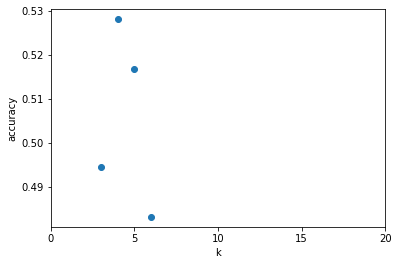

In [29]:
model_descriptions, comparison_chart = model_knn(feat_set, model_descriptions, comparison_chart, subsets)

In [30]:
model_descriptions.sort_values(by='Accuracy(Score)', ascending=False)

,Model,Accuracy(Score),Type,Features Used,Parameters
10,RF_5,0.786500,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 1"
4,DTC_3,0.696600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 6
3,DTC_2,0.640400,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 5
9,RF_4,0.573000,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 2"
2,DTC_1,0.550600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 4
8,RF_3,0.550600,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 3"
12,Knn_4,0.528090,Knn,"['word_count', 'lemmatized']",K-Neighbors: 4
13,Knn_5,0.516850,Knn,"['word_count', 'lemmatized']",K-Neighbors: 5
7,RF_2,0.505600,Random Forest,"['word_count', 'lemmatized']","Depth: 3, Leaves: 1"
11,Knn_3,0.494380,Knn,"['word_count', 'lemmatized']",K-Neighbors: 3


## Logistic Regression

In [31]:
def model_lr(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    cees = [.1,.5,1]
    solver = ['newton-cg', 'lbfgs']
    weights = [None, 'balanced']

    selectors = list(product(cees, solver, weights))

    for idx, item in enumerate(selectors):
        model_id = 'LR_'+f'{idx}'
        lr = LogisticRegression(C=item[0],\
                                solver=item[1],
                                class_weight=item[2],
                                max_iter=400,
                                random_state=514)
        
        lr.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(lr, X_train[features], y_train).values

        score = lr.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Logistic Regression',
            'Features Used': f'{feat_set}',
            'Parameters': f'C: {item[0]}, Solver: {item[1]}, Class Weight: {item[2]}'},
            index=[0])
        
        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [32]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/nlp_project/model.py'>

In [33]:
model_descriptions, comparison_chart = model_lr(feat_set, model_descriptions, comparison_chart, subsets)

## Model Description and Comparison Charts


In [34]:
model_descriptions.groupby('Type')['Accuracy(Score)'].mean()

Type
Basic Baseline              0.292135
Decision Tree Classifier    0.592675
Knn                         0.505618
Logistic Regression         0.213500
Random Forest               0.548683
Name: Accuracy(Score), dtype: float64

In [35]:
model_descriptions.head(20)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.292135,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.483100,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 3
2,DTC_1,0.550600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 4
3,DTC_2,0.640400,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 5
4,DTC_3,0.696600,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 6
5,RF_0,0.427000,Random Forest,"['word_count', 'lemmatized']","Depth: 3, Leaves: 3"
6,RF_1,0.449400,Random Forest,"['word_count', 'lemmatized']","Depth: 3, Leaves: 2"
7,RF_2,0.505600,Random Forest,"['word_count', 'lemmatized']","Depth: 3, Leaves: 1"
8,RF_3,0.550600,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 3"
9,RF_4,0.573000,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 2"


In [36]:
#model descriptions
model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(5)

,Model,Accuracy(Score),Type,Features Used,Parameters
10,RF_5,0.7865,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 1"
4,DTC_3,0.6966,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 6
3,DTC_2,0.6404,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 5
9,RF_4,0.5730,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 2"
8,RF_3,0.5506,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 3"


In [37]:
comparison_chart.T.sort_values(by='True Negatives', ascending=False).head(25).sort_values(by=['Accuracy/Score'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
RF_0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0
RF_1,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0
LR_11,0.4000,2.0,2.0,4.0,7.0,0.2222,0.3333,0.6667,0.7778,0.5,0.3077,9.0,6.0
LR_7,0.4000,2.0,2.0,4.0,7.0,0.2222,0.3333,0.6667,0.7778,0.5,0.3077,9.0,6.0
LR_3,0.4000,2.0,2.0,4.0,7.0,0.2222,0.3333,0.6667,0.7778,0.5,0.3077,9.0,6.0
LR_9,0.4375,2.0,2.0,5.0,7.0,0.2222,0.2857,0.7143,0.7778,0.5,0.3077,9.0,7.0
LR_5,0.4375,2.0,2.0,5.0,7.0,0.2222,0.2857,0.7143,0.7778,0.5,0.3077,9.0,7.0
LR_1,0.4375,2.0,2.0,5.0,7.0,0.2222,0.2857,0.7143,0.7778,0.5,0.3077,9.0,7.0
RF_4,0.8000,4.0,0.0,0.0,1.0,0.8000,0.0000,0.0000,0.2000,1.0,0.8889,5.0,0.0
Knn_4,0.8750,5.0,0.0,2.0,1.0,0.8333,0.0000,1.0000,0.1667,1.0,0.9091,6.0,2.0


In [38]:
comparison_chart.T.sort_values(by='Accuracy/Score', ascending=False).head(25).sort_values(by=['False Positives'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
DTC_0,1.0000,3.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0,1.0000,3.0,0.0
RF_4,0.8000,4.0,0.0,0.0,1.0,0.8000,0.0000,0.0000,0.2000,1.0,0.8889,5.0,0.0
Knn_4,0.8750,5.0,0.0,2.0,1.0,0.8333,0.0000,1.0000,0.1667,1.0,0.9091,6.0,2.0
DTC_2,1.0000,7.0,0.0,4.0,0.0,1.0000,0.0000,1.0000,0.0000,1.0,1.0000,7.0,4.0
DTC_3,1.0000,7.0,0.0,5.0,0.0,1.0000,0.0000,1.0000,0.0000,1.0,1.0000,7.0,5.0
RF_2,1.0000,2.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0,1.0000,2.0,0.0
RF_5,1.0000,7.0,0.0,5.0,0.0,1.0000,0.0000,1.0000,0.0000,1.0,1.0000,7.0,5.0
Knn_6,1.0000,6.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0,1.0000,6.0,0.0
Knn_5,1.0000,6.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0,1.0000,6.0,0.0
RF_3,1.0000,4.0,0.0,0.0,0.0,1.0000,0.0000,0.0000,0.0000,1.0,1.0000,4.0,0.0


In [39]:
model_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Model            27 non-null     object 
 1   Accuracy(Score)  27 non-null     float64
 2   Type             27 non-null     object 
 3   Features Used    27 non-null     object 
 4   Parameters       27 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.2+ KB


## Model Creation Takeaways
- Had to abandon gridsearch script for lack of feasability
- KNN underperforming with initial set of hyper parameters
- KNN and Logistic regression continued to be low perfoming


Model	Accuracy(Score)	Type	Features Used	Parameters
10	RF_5	0.79790	Random Forest	['word_count', 'lemmatized']	Depth: 7, Leaves: 1
9	RF_4	0.61700	Random Forest	['word_count', 'lemmatized']	Depth: 7, Leaves: 2
4	DTC_3	0.59570	Decision Tree Classifier	['word_count', 'lemmatized']	Depth: 6
3	DTC_2	0.55320	Decision Tree Classifier	['word_count', 'lemmatized']	Depth: 5
11	Knn_3	0.51064	Knn	['word_count', 'lemmatized']	K-Neighbors: 3

## Validation - Top 5 Models from Train section

Model	| Accuracy(Score)|Type                  |Features Used                  |Parameters             |
|---    | ---            |---                   |   -----                       |---                    |
|RF_5   |	0.79790 |Random Forest              |	['word_count', 'lemmatized']|	Depth: 20, Leaves: 1
|RF_4   |	0.61700 |Random Forest              |	['word_count', 'lemmatized']|	Depth: 25, Leaves: 1
|DTC3   |   0.59570 |Decision Tree Classifier   |	['word_count', 'lemmatized']|	Depth: 9
|DTC_2  |	0.55320	|Decision Tree Classifier	|['word_count', 'lemmatized']	|Depth: 8
|KNN_3  |	0.51064	|Decision Tree Classifier	|['word_count', 'lemmatized']	|Depth: 7

In [40]:
def validate_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate=subsets[3]
    y_validate=subsets[4]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(5,7,1)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_validate[features], y_validate).values

        score = dtc.score(X_validate[features], y_validate).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

## Random Forest

In [41]:
def validate_rf(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate=subsets[3]
    y_validate=subsets[4]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product([7], [1,2]))

    for idx, item in enumerate(selectors):
        model_id = 'RF_'+f'{idx}'
        rf = RandomForestClassifier(max_depth=item[0],\
                                            min_samples_leaf=item[1],
                                            random_state=514)
        
        rf.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(rf, X_validate[features], y_validate).values

        score = rf.score(X_validate[features], y_validate).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Random Forest',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}, Leaves: {item[1]}'},
                                    index=[0])
       
        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [42]:
## K-Nearest Neighbors
def validate_knn(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate=subsets[3]
    y_validate=subsets[4]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    k_range = range(3, 4)
    scores = []
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[features], y_train)
        scores.append(knn.score(X_train[features], y_train))

        model_id = 'Knn_'+f'{k}'

        comparison_chart[model_id] = model.compute_metrics(knn, X_validate[features], y_validate).values

        score = knn.score(X_validate[features], y_validate).round(5)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Knn',
            'Features Used': f'{feat_set}',
            'Parameters': f'K-Neighbors: {k}'},
            index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)
   
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks([0,5,10,15,20])
    plt.show()
    np.mean(scores)

    
    return model_descriptions, comparison_chart

In [43]:
validate_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

val_comparisons = model.create_comp_chart()

In [44]:
validate_descriptions, val_comparisons =  validate_dtc(feat_set, validate_descriptions, val_comparisons, subsets)

In [45]:
validate_descriptions, val_comparisons =  validate_rf(feat_set, validate_descriptions, val_comparisons, subsets)

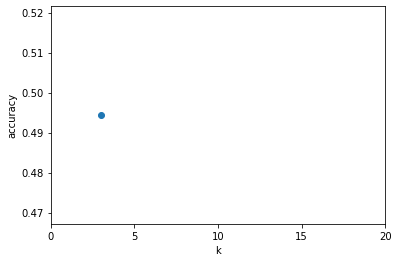

In [46]:
validate_descriptions, val_comparisons =  validate_knn(feat_set, validate_descriptions, val_comparisons, subsets)

In [47]:
validate_descriptions.sort_values(by='Accuracy(Score)', ascending=False).head(5)

,Model,Accuracy(Score),Type,Features Used,Parameters
1,DTC_0,0.307700,Decision Tree Classifier,"['word_count', 'lemmatized']",Depth: 5
4,RF_1,0.307700,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 2"
0,Baseline,0.292135,Basic Baseline,Baseline Prediction,n/a
3,RF_0,0.282100,Random Forest,"['word_count', 'lemmatized']","Depth: 7, Leaves: 1"
5,Knn_3,0.256410,Knn,"['word_count', 'lemmatized']",K-Neighbors: 3


In [94]:
val_comparisons

,DTC_0,DTC_1,RF_0,RF_1,Knn_3
Accuracy/Score,0.0,0.0,0.0,0.0,0.3333
True Positives,0.0,0.0,0.0,0.0,1.0000
False Positives,1.0,1.0,1.0,1.0,1.0000
True Negatives,0.0,0.0,0.0,0.0,0.0000
False Negatives,0.0,0.0,0.0,0.0,1.0000
TPR/Recall,0.0,0.0,0.0,0.0,0.5000
False Positive Rate,1.0,1.0,1.0,1.0,1.0000
True Negative Rate,0.0,0.0,0.0,0.0,0.0000
False Negative Rate,0.0,0.0,0.0,0.0,0.5000
Precision,0.0,0.0,0.0,0.0,0.5000


## Validation Takeaways
- Massive performance drop from Train set. 
- Indicative of over fitting. 
- Adjusting input data for hopeful performance gains.
- Validation Performance on Top 5 from Train

## Test
- The Top performing model from Validation


## Modeling Takeaways
- THings did not go as plan.
- Had to abandon gridsearch idea
- Logistic Regression never provided much performance gain above baseline